In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
all_new = pd.read_csv('data/feature_df.csv')
wordvec_df = pd.read_csv('sub_notebook/data/wordvectorized_df.csv')
bert_embeded = pd.read_csv('kaggle-notebook/data/bert_embeded.csv')
#tfidf_1000 = pd.read_csv('data/tfidf_1000.csv')
tfidf_svd_raw_64 = pd.read_csv("data/tfidf_svd_raw_64.csv")
#tfidf_svd_content_64 = pd.read_csv("data/tfidf_svd_content_64.csv")
#tfidf_svd_compiled_64 = pd.read_csv("data/tfidf_svd_compiled_64.csv")
mfw_df = pd.read_csv('data/mfw.csv')
miw_df = pd.read_csv('data/miw.csv')

In [3]:
all_new = pd.merge(all_new, bert_embeded, on="id", how="outer")
all_new = pd.merge(all_new, tfidf_svd_raw_64, on="id", how="outer")
all_new = pd.merge(all_new, wordvec_df, on="id", how="outer")
all_new = pd.merge(all_new, miw_df, on="id", how="outer")
all_new = pd.merge(all_new, mfw_df.drop(["mfw", "sfw"], axis=1), on="id", how="outer")

In [4]:
test_data = all_new[all_new["data_type"] == "test"]
train_data = all_new[all_new["data_type"] == "train"]

In [5]:
with open("data/lgbm_config_svd64_raw.json") as f:
    optuna_config_dict = json.load(f)

feature_cols = optuna_config_dict["selected_feature"]

In [6]:
all_kmeans = all_new.drop(["id", "state", "data_type"], axis=1)
all_kmeans = all_kmeans[feature_cols]
all_kmeans = all_kmeans.fillna(-1)

In [23]:
n_clusters = 24

cf_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300,
                   tol=0.0001,precompute_distances='auto', verbose=0,
                   random_state=None, copy_x=True)

preds = cf_kmeans.fit_predict(all_kmeans)

/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:932: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "


In [24]:
all_kmeans["kmeans_group"] = preds
f_groups = all_kmeans[all_new["state"] == 0]["kmeans_group"]
t_groups = all_kmeans[all_new["state"] == 1]["kmeans_group"]

'\nfor group in all_kmeans["kmeans_group"].unique():\n    print(f"state == 0: group{group}: {list(f_groups).count(group)}")\n    print(f"state == 1: group{group}: {list(t_groups).count(group)}")\n'

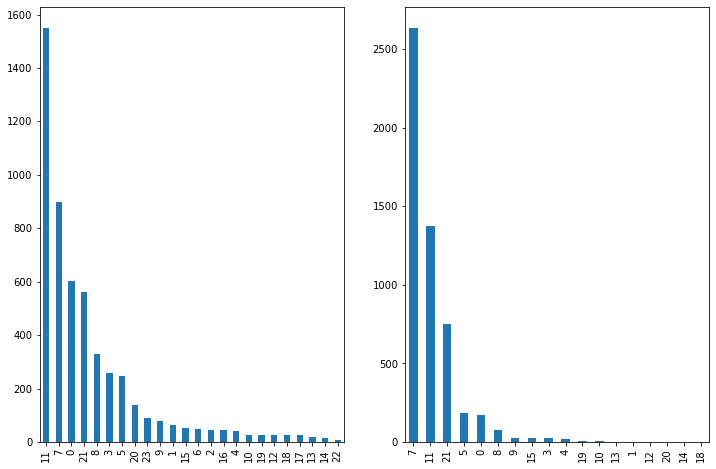

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
f_groups.value_counts().plot(kind="bar")
plt.subplot(1,2,2)
t_groups.value_counts().plot(kind="bar")

"""
for group in all_kmeans["kmeans_group"].unique():
    print(f"state == 0: group{group}: {list(f_groups).count(group)}")
    print(f"state == 1: group{group}: {list(t_groups).count(group)}")
"""

In [26]:
oof = list(all_kmeans[all_kmeans.index.isin(train_data.index)]["kmeans_group"].astype(int))
pred = list(all_kmeans[all_kmeans.index.isin(test_data.index)]["kmeans_group"].astype(int))

config_dict = {
    "out_of_fold": oof,
    "prediction": pred,
}

with open("data/kmeans24_svd64_raw.json", 'w') as f:
    json.dump(config_dict, f)